# Life Expectancy: Exploratory Data Analysis
Goal: Find a set of features that affect Life Expectancy.
1. Data Cleaning
2. Data Exploration
3. Feature Engineering
4. Summary

## Imports and Dataset Load

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import os
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

filepath = '/content/gdrive/My Drive/Colab Notebooks/life_expectancy_data.csv'
df = pd.read_csv(filepath)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Now that the dataset is loaded into the DataFrame, `df`, it is now time to begin the EDA. The first step of any EDA is data cleaning (AKA data wrangling, data munging, data cleansing).

# Section 1: Data Cleaning

In order to properly clean the data, it is important to understand the variables presented in the data. There are a number of things important to know about each variable:
1. What does the variable mean and what type of variable is it (Nominal/Ordinal/Interval/Ratio)?
2. Does the variable have missing values? If so, what should be done about them?
3. Does the variable have outliers? If so, what should be done about them?

Each of these questions will be answered in turn for all the variables. And those answers can be found in this section.

### 1.1: Dataset Description/Variable Descriptions

#### Dataset Description
This dataset is comprised of data from all over the world from various countries aggregated by the World Health Organization (WHO for short). The data is an aggregate of many indicators for a particular country in a particular year. In essence, the data is multiple indicators in a time series separated by country. A more in depth look into the context, content, acknowledgments, and inspiration for this dataset can be found [here](https://www.kaggle.com/kumarajarshi/life-expectancy-who).

Before getting into the variable descriptions, the string values for the columns/variables themselves are not very 'clean' so the following is a quick cleaning of the column/variable titles.

In [ ]:
orig_cols = list(df.columns)
new_cols = []
for col in orig_cols:
    new_cols.append(col.strip().replace('  ', ' ').replace(' ', '_').lower())
df.columns = new_cols

#### Variable Descriptions
Format: variable (type) - description
- country (Nominal) - the country in which the indicators are from (i.e. United States of America or Congo)
- year (Ordinal) - the calendar year the indicators are from (ranging from 2000 to 2015)
- status (Nominal) - whether a country is considered to be 'Developing' or 'Developed' by WHO standards
- life_expectancy (Ratio) - the life expectancy of people in years for a particular country and year
- adult_mortality (Ratio) - the adult mortality rate per 1000 population (i.e. number of people dying between 15 and 60 years per 1000 population); if the rate is 263 then that means 263 people will die out of 1000 between the ages of 15 and 60; another way to think of this is that the chance an individual will die between 15 and 60 is 26.3%
- infant_deaths (Ratio) - number of infant deaths per 1000 population; similar to above, but for infants
- alcohol (Ratio) - a country's alcohol consumption rate measured as liters of pure alcohol consumption per capita
- percentage_expenditure (Ratio) - expenditure on health as a percentage of Gross Domestic Product (gdp)
- hepatitis_b (Ratio) - number of 1 year olds with Hepatitis B immunization over all 1 year olds in population
- measles (Ratio) - number of reported Measles cases per 1000 population
- bmi (Interval/Ordinal) - average Body Mass Index (BMI) of a country's total population
- under-five_deaths (Ratio) - number of people under the age of five deaths per 1000 population
- polio (Ratio) - number of 1 year olds with Polio immunization over the number of all 1 year olds in population
- total_expenditure (Ratio) - government expenditure on health as a percentage of total government expenditure
- diphtheria (Ratio) - Diphtheria tetanus toxoid and pertussis (DTP3) immunization rate of 1 year olds
- hiv/aids (Ratio) - deaths per 1000 live births caused by HIV/AIDS for people under 5; number of people under 5 who die due to HIV/AIDS per 1000 births
- gdp (Ratio) - Gross Domestic Product per capita
- population (Ratio) - population of a country
- thinness_1-19_years (Ratio) - rate of thinness among people aged *10-19* (Note: variable should be renamed to *thinness_10-19_years* to more accurately represent the variable)
- thinness_5-9_years (Ratio) - rate of thinness among people aged 5-9
- income_composition_of_resources (Ratio) - Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
- schooling (Ratio) - average number of years of schooling of a population

As stated above it would be useful to change the name of the variable `thinness_1-19_years` to `thinness_10-19_years` as it is a more accurate depiction of what the variable means.

In [ ]:
df.rename(columns={'thinness_1-19_years':'thinness_10-19_years'}, inplace=True)

Now that the descriptions of the dataset and variables have been made, a look at the missing values of each variable should be done.

### 1.2: Missing Values

There are few things that must be done concerning missing values:
1. Detection of missing values
    - Find nulls
    - Could a null be signified by anything other than null? Zero values perhaps?
2. Dealing with missing values
    - Fill nulls? Impute or Interpolate
    - Eliminate nulls?

#### 1.2.1: Missing Values Detection

##### Finding possible inexplicit nulls
These nulls would be missing values that aren't necessarily easy to find using the `df.info()` method.
- What values could be null?
- What values could be erroneous?

**Inexplicit Nulls**\
The easiest and quickest method here would be to do a quick `df.describe()` and look at each variable on its own to see if the values make sense given the description of the variable.

In [ ]:
df.describe().iloc[:, 1:].transpose().round(0)

,count,mean,std,min,25%,50%,75%,max
life_expectancy,2928.0,69.0,10.0,36.0,63.0,72.0,76.0,8.900000e+01
adult_mortality,2928.0,165.0,124.0,1.0,74.0,144.0,228.0,7.230000e+02
infant_deaths,2938.0,30.0,118.0,0.0,0.0,3.0,22.0,1.800000e+03
alcohol,2744.0,5.0,4.0,0.0,1.0,4.0,8.0,1.800000e+01
percentage_expenditure,2938.0,738.0,1988.0,0.0,5.0,65.0,442.0,1.948000e+04
hepatitis_b,2385.0,81.0,25.0,1.0,77.0,92.0,97.0,9.900000e+01
measles,2938.0,2420.0,11467.0,0.0,0.0,17.0,360.0,2.121830e+05
bmi,2904.0,38.0,20.0,1.0,19.0,44.0,56.0,8.700000e+01
under-five_deaths,2938.0,42.0,160.0,0.0,0.0,4.0,28.0,2.500000e+03
polio,2919.0,83.0,23.0,3.0,78.0,93.0,97.0,9.900000e+01


Things that may not make sense from above:
- Adult mortality of 1? This is likely an error in measurement, but what values make sense here? May need to change to null if under a certain threshold.
- Infant deaths as low as 0 per 1000? That just isn't plausible - I'm deeming those values to actually be null. Also on the other end 1800 is likely an outlier, but it is possible in a country with very high birthrates and perhaps a not very high population total - this can be dealt with later.
- BMI of 1 and 87.3? Pretty sure the whole population would not exist if that were the case. A BMI of 15 or lower is seriously underweight and a BMI of 40 or higher is morbidly obese, therefore a large number of these measurements just seem unrealistic...this variable might not be worth digging into at all.
- Under Five Deaths, similar to infant deaths just isn't likely (perhaps even impossible) to have values at zero.
- GDP per capita as low as 1.68 (USD) possible? Doubtful - but perhaps values this low are outliers.
- Population of 34 for an entire country? Hmm...

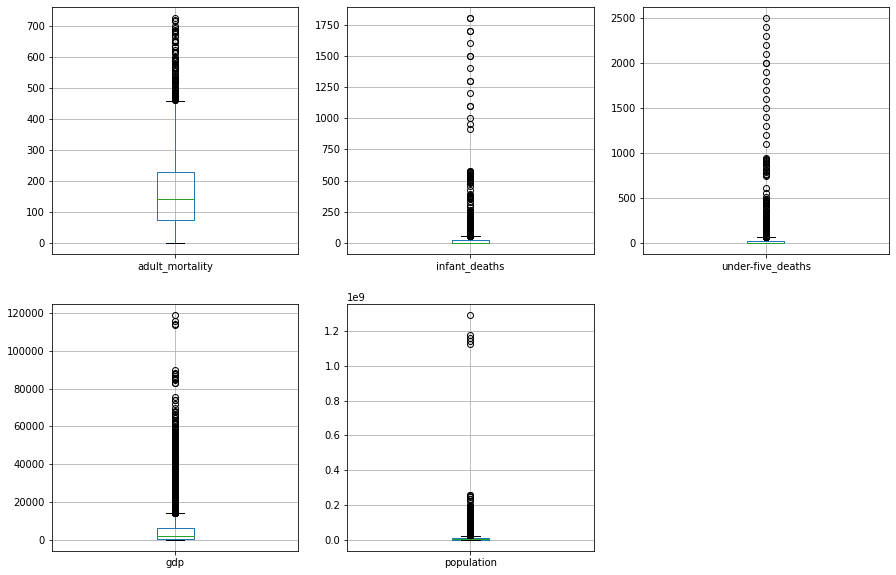

In [ ]:
plt.figure(figsize=(15,10))
for i, col in enumerate(['adult_mortality', 'infant_deaths',  'under-five_deaths', 'gdp', 'population'], start=1):
    plt.subplot(2, 3, i)
    df.boxplot(col)

There are a few of the above that could simply be outliers, but there are some that almost certainly have to be errors of some sort. Of the above variables, changes to null will be made for the following since these numbers don't make any sense:
1. Adult mortality rates lower than the 5th percentile
2. Infant deaths of 0
3. BMI less than 10 and greater than 50
4. Under Five deaths of 0

In [ ]:
mort_5_percentile = np.percentile(df.adult_mortality.dropna(), 5)
df.adult_mortality = df.apply(lambda x: np.nan if x.adult_mortality < mort_5_percentile else x.adult_mortality, axis=1)
df.infant_deaths = df.infant_deaths.replace(0, np.nan)
#df.bmi = df.apply(lambda x: np.nan if (x.bmi < 10 or x.bmi > 50) else x.bmi, axis=1)
df['under-five_deaths'] = df['under-five_deaths'].replace(0, np.nan)

##### All missing values (all explicit now)
Easy way to do this is with `df.info()`:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          2938 non-null   object 
 1   year                             2938 non-null   int64  
 2   status                           2938 non-null   object 
 3   life_expectancy                  2928 non-null   float64
 4   adult_mortality                  2783 non-null   float64
 5   infant_deaths                    2090 non-null   float64
 6   alcohol                          2744 non-null   float64
 7   percentage_expenditure           2938 non-null   float64
 8   hepatitis_b                      2385 non-null   float64
 9   measles                          2938 non-null   int64  
 10  bmi                              2904 non-null   float64
 11  under-five_deaths                2153 non-null   float64
 12  polio               

It appears that there are a decent amount of null values, may be of more use to break down the data into those that contain nulls in order to take a closer look. The function below attempts to do just that - it only returns the columns that contain (explicit) nulls, keeps a running total of those columns with nulls as well as their location in the dataframe, returns the count of nulls in a specified column and the percent of nulls out of all the values in the column.

In [ ]:
def nulls_breakdown(df=df):
    df_cols = list(df.columns)
    cols_total_count = len(list(df.columns))
    cols_count = 0
    for loc, col in enumerate(df_cols):
        null_count = df[col].isnull().sum()
        total_count = df[col].isnull().count()
        percent_null = round(null_count/total_count*100, 2)
        if null_count > 0:
            cols_count += 1
            print('[row {}] {} has {} null values: {}% null'.format(loc, col, null_count, percent_null))
    cols_percent_null = round(cols_count/cols_total_count*100, 2)
    print('Out of {} total columns, {} contain null values; {}% columns contain null values.'.format(cols_total_count, cols_count, cols_percent_null))

In [ ]:
df.isnull().sum()/len(df)*100

country                             0.000000
year                                0.000000
status                              0.000000
life_expectancy                     0.340368
adult_mortality                     5.275698
infant_deaths                      28.863172
alcohol                             6.603131
percentage_expenditure              0.000000
hepatitis_b                        18.822328
measles                             0.000000
bmi                                 1.157250
under-five_deaths                  26.718856
polio                               0.646698
total_expenditure                   7.692308
diphtheria                          0.646698
hiv/aids                            0.000000
gdp                                15.248468
population                         22.191967
thinness_10-19_years                1.157250
thinness_5-9_years                  1.157250
income_composition_of_resources     5.684139
schooling                           5.547992
dtype: flo

In [ ]:
nulls_breakdown()

[row 3] life_expectancy has 10 null values: 0.34% null
[row 4] adult_mortality has 155 null values: 5.28% null
[row 5] infant_deaths has 848 null values: 28.86% null
[row 6] alcohol has 194 null values: 6.6% null
[row 8] hepatitis_b has 553 null values: 18.82% null
[row 10] bmi has 34 null values: 1.16% null
[row 11] under-five_deaths has 785 null values: 26.72% null
[row 12] polio has 19 null values: 0.65% null
[row 13] total_expenditure has 226 null values: 7.69% null
[row 14] diphtheria has 19 null values: 0.65% null
[row 16] gdp has 448 null values: 15.25% null
[row 17] population has 652 null values: 22.19% null
[row 18] thinness_10-19_years has 34 null values: 1.16% null
[row 19] thinness_5-9_years has 34 null values: 1.16% null
[row 20] income_composition_of_resources has 167 null values: 5.68% null
[row 21] schooling has 163 null values: 5.55% null
Out of 22 total columns, 16 contain null values; 72.73% columns contain null values.


#### 1.2.2: Dealing with Missing Values

Nearly half of the BMI variable's values are null, it is likely best to remove this variable altogether.

In [ ]:
df.drop('bmi',inplace=True, axis=1)

Alright, so it looks like there are a lot of columns containing null values, since this is time series data assorted by country, the best course of action would be to interpolate the data by country. However, when attempting to interpolate by country it doesn't fill in any values as the countries' data for all the null values are null for each year, therefore imputation by year may be the best possible method here. Imputation of each year's mean is done below.

In [ ]:
imputed_data = []
for year in list(df.year.unique()):
    year_data = df[df.year == year].copy()
    for col in list(year_data.columns)[3:]:
        year_data[col] = year_data[col].fillna(year_data[col].dropna().mean()).copy()
    imputed_data.append(year_data)
df = pd.concat(imputed_data).copy()

One more look at the null values...

In [ ]:
nulls_breakdown(df)

Out of 21 total columns, 0 contain null values; 0.0% columns contain null values.


Appears that this method took care of the null values. Hopefully meaningful results can still be garnered using this method. Next up, outliers...

### 1.3: Outliers

Similar to missing values, there are a few things that need done in order to deal with outliers:
1. Detect the outliers
    - Boxplots/histograms
    - Tukey's Method
2. Deal with outliers
    - Drop outliers?
    - Limit/Winsorize outliers?
    - Transform the data using log/inverse/square root/etc?

#### 1.3.1: Outliers Detection

First a boxplot and histogram will be created for each continuous variable in order to visually see if outliers exist.

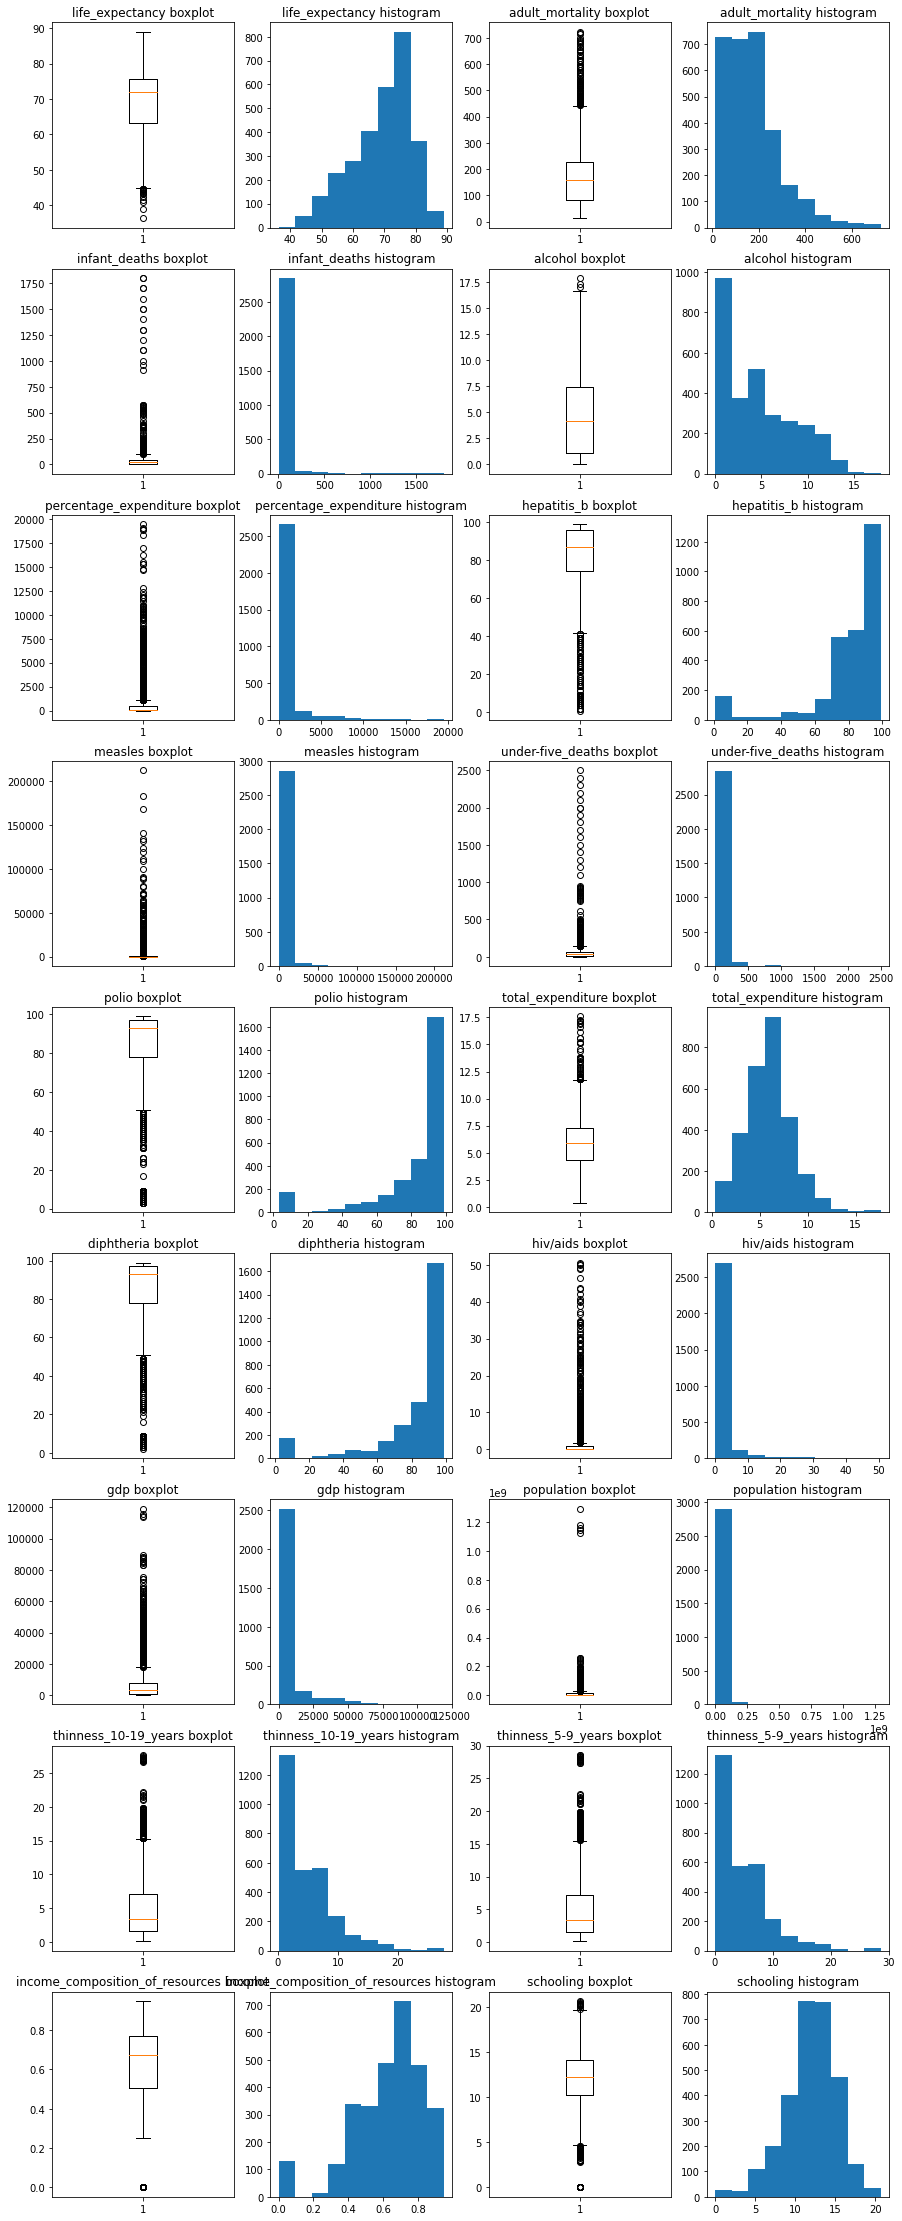

In [ ]:
cont_vars = list(df.columns)[3:]
def outliers_visual(data):
    plt.figure(figsize=(15, 40))
    i = 0
    for col in cont_vars:
        i += 1
        plt.subplot(9, 4, i)
        plt.boxplot(data[col])
        plt.title('{} boxplot'.format(col))
        i += 1
        plt.subplot(9, 4, i)
        plt.hist(data[col])
        plt.title('{} histogram'.format(col))
    plt.show()
outliers_visual(df)

Visually, it is plain to see that there are a number of outliers for all of these variables - including the target variable, life expectancy. The same will be done statistically using Tukey's method below - outliers being considered anything outside of 1.5 times the IQR.

In [ ]:
def outlier_count(col, data=df):
    print(15*'-' + col + 15*'-')
    q75, q25 = np.percentile(data[col], [75, 25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    outlier_count = len(np.where((data[col] > max_val) | (data[col] < min_val))[0])
    outlier_percent = round(outlier_count/len(data[col])*100, 2)
    print('Number of outliers: {}'.format(outlier_count))
    print('Percent of data that is outlier: {}%'.format(outlier_percent))

In [ ]:
for col in cont_vars:
    outlier_count(col)

---------------life_expectancy---------------
Number of outliers: 17
Percent of data that is outlier: 0.58%
---------------adult_mortality---------------
Number of outliers: 97
Percent of data that is outlier: 3.3%
---------------infant_deaths---------------
Number of outliers: 135
Percent of data that is outlier: 4.59%
---------------alcohol---------------
Number of outliers: 3
Percent of data that is outlier: 0.1%
---------------percentage_expenditure---------------
Number of outliers: 389
Percent of data that is outlier: 13.24%
---------------hepatitis_b---------------
Number of outliers: 222
Percent of data that is outlier: 7.56%
---------------measles---------------
Number of outliers: 542
Percent of data that is outlier: 18.45%
---------------under-five_deaths---------------
Number of outliers: 142
Percent of data that is outlier: 4.83%
---------------polio---------------
Number of outliers: 279
Percent of data that is outlier: 9.5%
---------------total_expenditure---------------

It appears there are a decent amount of outliers in this dataset. Now that they have been detected, what should be done with them?

#### 1.3.2: Dealing with Outliers

There are a number of ways to deal with outliers in a dataset, the usual options are as follows:
1. Drop Outliers (best avoided in order to keep as much information as possible)
2. Limit values to upper and/or lower bounds (Winsorize the data)
3. Transform the data (log/inverse/square root/etc.)
    - advantage: can 'normalize' the data and eliminate outliers
    - disadvantage: cannot be done to variables containing values of 0 or below

Since each variable has a unique amount of outliers and also has outliers on different sides of the data, the best route to take is probably winsorizing (limiting) the values for each variable on its own until no outliers remain. The function below allows me to do exactly that by going variable by variable with the ability to use a lower limit and/or upper limit for winsorization. By default the function will show two boxplots side by side for the variable (one boxplot of the original data, and one with the winsorized change). Once a satisfactory limit is found (by visual analysis), the winsorized data will be saved in the `wins_dict` dictionary so the data can easily be accessed later.

In [ ]:
def test_wins(col, lower_limit=0, upper_limit=0, show_plot=True):
    wins_data = winsorize(df[col], limits=(lower_limit, upper_limit))
    wins_dict[col] = wins_data
    if show_plot == True:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.boxplot(df[col])
        plt.title('original {}'.format(col))
        plt.subplot(122)
        plt.boxplot(wins_data)
        plt.title('wins=({},{}) {}'.format(lower_limit, upper_limit, col))
        plt.show()

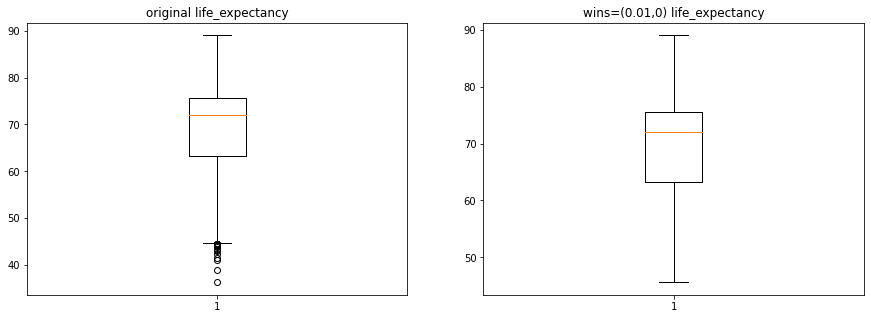

In [ ]:
wins_dict = {}
test_wins(cont_vars[0], lower_limit=.01, show_plot=True)
test_wins(cont_vars[1], upper_limit=.04, show_plot=False)
test_wins(cont_vars[2], upper_limit=.05, show_plot=False)
test_wins(cont_vars[3], upper_limit=.0025, show_plot=False)
test_wins(cont_vars[4], upper_limit=.135, show_plot=False)
test_wins(cont_vars[5], lower_limit=.1, show_plot=False)
test_wins(cont_vars[6], upper_limit=.19, show_plot=False)
test_wins(cont_vars[7], upper_limit=.05, show_plot=False)
test_wins(cont_vars[8], lower_limit=.1, show_plot=False)
test_wins(cont_vars[9], upper_limit=.02, show_plot=False)
test_wins(cont_vars[10], lower_limit=.105, show_plot=False)
test_wins(cont_vars[11], upper_limit=.185, show_plot=False)
test_wins(cont_vars[12], upper_limit=.105, show_plot=False)
test_wins(cont_vars[13], upper_limit=.07, show_plot=False)
test_wins(cont_vars[14], upper_limit=.035, show_plot=False)
test_wins(cont_vars[15], upper_limit=.035, show_plot=False)
test_wins(cont_vars[16], lower_limit=.05, show_plot=False)
test_wins(cont_vars[17], lower_limit=.025, upper_limit=.005, show_plot=False)

The plot above is an example of how the winsorization is visually inspected (the rest are not shown for brevity).

All the variables have now been winsorized as little as possible in order to keep as much data in tact as possible while still being able to eliminate the outliers. Finally, small boxplots will be shown for each variable's winsorized data to show that the outliers have indeed been dealt with.

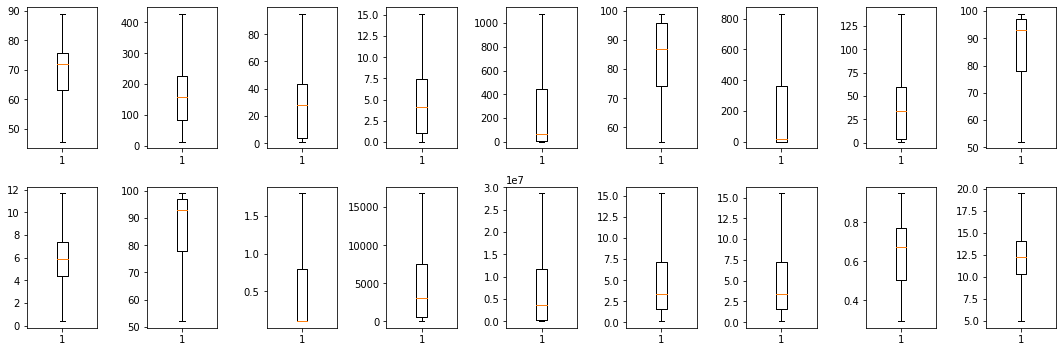

In [ ]:
plt.figure(figsize=(15,5))
for i, col in enumerate(cont_vars, 1):
    plt.subplot(2, 9, i)
    plt.boxplot(wins_dict[col])
plt.tight_layout()
plt.show()

Now that the outliers have been dealt with, the data cleaning section is complete.

# Section 2: Data Exploration

Before diving into exploration, a new dataframe with the winsorized data should be created.

In [ ]:
wins_df = df.iloc[:, 0:3]
for col in cont_vars:
    wins_df[col] = wins_dict[col]

With that out of the way, the main areas of interest in this section are as follows:
1. Univariate Analysis
    - Continuous variables
    - Categorical Variables
2. Bivariate Analysis
    - Continuous to Continuous variables
    - Continuous to Categorical variables
    - Categorical to Categorical variables

### 2.1: Univariate Analysis

Univariate analysis is looking at the data for each variable on its own. This is generally done best by using histograms for continuous data, count/barplots for categorical data and of course by getting the descriptive stats by using `.describe()`.

**Descriptive Statistics**

In [ ]:
wins_df.describe().transpose().round(0)

,count,mean,std,min,25%,50%,75%,max
year,2938.0,2008.0,5.0,2000.0,2004.0,2008.0,2012.0,2015.0
life_expectancy,2938.0,69.0,9.0,46.0,63.0,72.0,76.0,89.0
adult_mortality,2938.0,169.0,108.0,13.0,84.0,157.0,227.0,428.0
infant_deaths,2938.0,29.0,26.0,1.0,4.0,28.0,44.0,95.0
alcohol,2938.0,5.0,4.0,0.0,1.0,4.0,7.0,15.0
percentage_expenditure,2938.0,282.0,384.0,0.0,5.0,65.0,442.0,1078.0
hepatitis_b,2938.0,84.0,14.0,55.0,74.0,87.0,96.0,99.0
measles,2938.0,221.0,329.0,0.0,0.0,17.0,360.0,831.0
under-five_deaths,2938.0,39.0,38.0,1.0,4.0,34.0,60.0,138.0
polio,2938.0,86.0,15.0,52.0,78.0,93.0,97.0,99.0


**Visual Distributions**

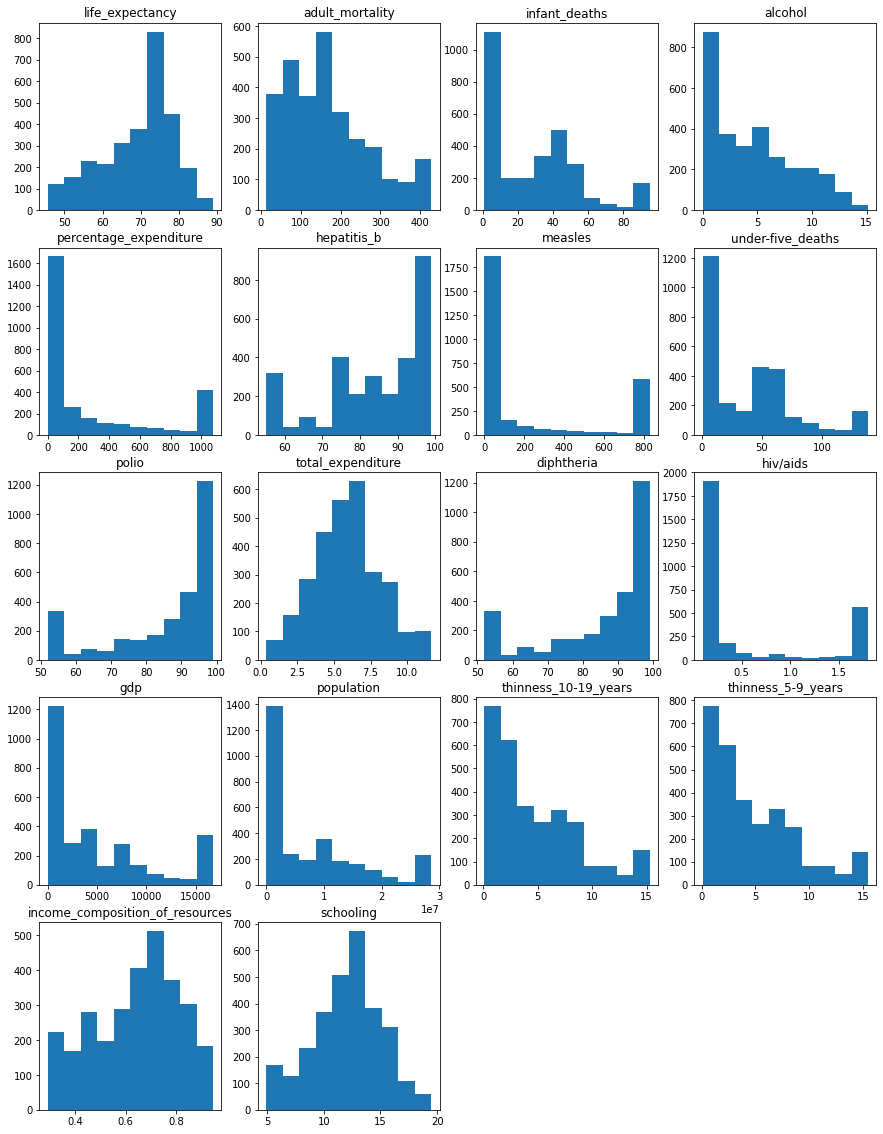

In [ ]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(cont_vars, 1):
    plt.subplot(5, 4, i)
    plt.hist(wins_df[col])
    plt.title(col)

The winsorization had a large effect on some variables while not having too much of an effect on others. Even though all of these variables were winsorized in some fashion, some variables are much more obviously winsorized than others. What about the categorical variables, how many of each of these are there in the data (in essence, what is their distribution?)

Again, not the most useful plot, but does display that each year has the same amount of rows, except for 2013, which contains 10 more rows than the rest (the countries with only one row from the prior graph's data must be from 2013 alone). This shouldn't have a detrimental effect on analysis.

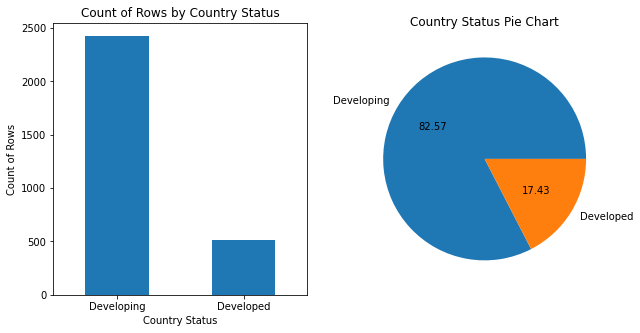

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
wins_df.status.value_counts().plot(kind='bar')
plt.title('Count of Rows by Country Status')
plt.xlabel('Country Status')
plt.ylabel('Count of Rows')
plt.xticks(rotation=0)

plt.subplot(122)
wins_df.status.value_counts().plot(kind='pie', autopct='%.2f')
plt.ylabel('')
plt.title('Country Status Pie Chart')

plt.show()

This graph, though simple, is important. The above displays that the majority of our data comes from countries listed as 'Developing' - 82.57% to be exact. It is likely that any model used will more accurately depict results for 'Developing' countries over 'Developed' countries as the majority of the data lies within countries that are 'Developing' rather than 'Developed'.

### 2.2: Bivariate Analysis

There are a number of things that should be examined here:
1. Continuous variables compared to the life expectancy (target variable) and to one another
2. Categorical variables compared to the life expectancy (target variable)
3. Comparison of Country Status and Year to Continuous variables (country has an extremely large number of values with small sample sizes, so country comparisons aren't especially helpful for this dataset)

#### 2.2.1: Continuous to Continuous Analysis

In [ ]:
wins_df[cont_vars].corr()

,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
life_expectancy,1.000000,-0.677680,-0.222292,0.395089,0.488440,0.315120,-0.337887,-0.298626,0.573291,0.222306,0.578952,-0.796939,0.501011,0.011363,-0.514966,-0.512694,0.792878,0.742306
adult_mortality,-0.677680,1.000000,0.119906,-0.187971,-0.293870,-0.214673,0.216200,0.168908,-0.348198,-0.121052,-0.351136,0.596271,-0.297774,-0.000562,0.332904,0.339266,-0.511340,-0.450785
infant_deaths,-0.222292,0.119906,1.000000,-0.062119,-0.094053,-0.196145,0.323610,0.966996,-0.217511,-0.086289,-0.225997,0.124310,-0.059337,0.176352,0.196669,0.202573,-0.178389,-0.191062
alcohol,0.395089,-0.187971,-0.062119,1.000000,0.378069,0.106352,-0.197193,-0.104954,0.265830,0.308434,0.272948,-0.193443,0.389598,-0.036283,-0.436755,-0.427166,0.475112,0.519757
percentage_expenditure,0.488440,-0.293870,-0.094053,0.378069,1.000000,0.122870,-0.194687,-0.131361,0.268385,0.159830,0.268411,-0.295791,0.712940,-0.070366,-0.331693,-0.333748,0.556006,0.530422
hepatitis_b,0.315120,-0.214673,-0.196145,0.106352,0.122870,1.000000,-0.266487,-0.239049,0.608008,0.071100,0.647198,-0.278977,0.172066,-0.004936,-0.134103,-0.139528,0.299493,0.290399
measles,-0.337887,0.216200,0.323610,-0.197193,-0.194687,-0.266487,1.000000,0.368517,-0.320104,-0.161737,-0.315164,0.226305,-0.183792,0.222488,0.359571,0.364201,-0.274976,-0.329274
under-five_deaths,-0.298626,0.168908,0.966996,-0.104954,-0.131361,-0.239049,0.368517,1.000000,-0.281667,-0.096826,-0.291057,0.198160,-0.102372,0.180288,0.235471,0.236927,-0.253539,-0.264996
polio,0.573291,-0.348198,-0.217511,0.265830,0.268385,0.608008,-0.320104,-0.281667,1.000000,0.164149,0.855849,-0.475611,0.309033,0.003618,-0.288660,-0.287206,0.515361,0.509788
total_expenditure,0.222306,-0.121052,-0.086289,0.308434,0.159830,0.071100,-0.161737,-0.096826,0.164149,1.000000,0.176715,-0.110629,0.146954,-0.105257,-0.285700,-0.294560,0.185535,0.259746


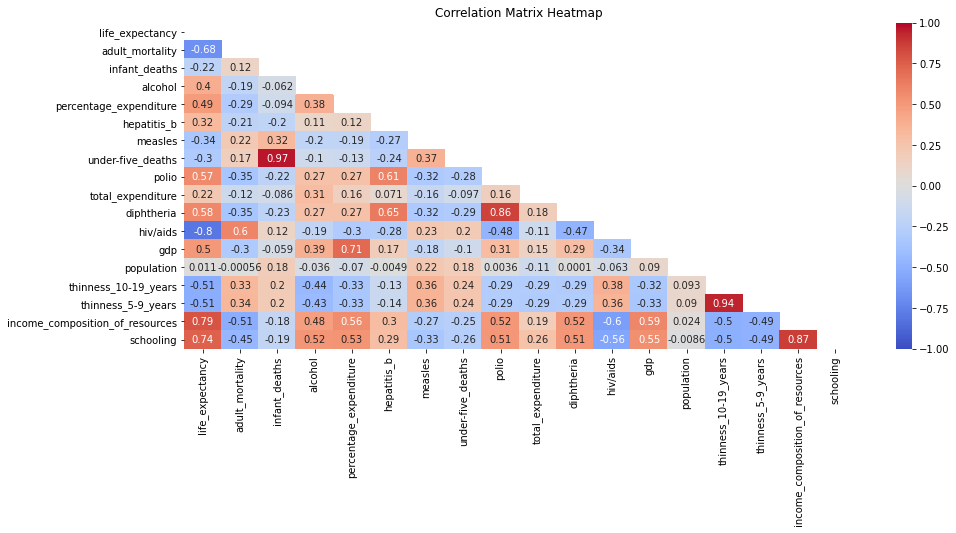

In [ ]:
mask = np.triu(wins_df[cont_vars].corr())
plt.figure(figsize=(15,6))
sns.heatmap(wins_df[cont_vars].corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
plt.ylim(18, 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

Note: the values above show rounding at the final two digits, for more exact values, reference the correlation matrix.

The above heatmap is very useful! It very easily displays a number of important correlations between variables. Some general takeaways from the graphic above:
- Life Expectancy (target variable) appears to be relatively highly correlated (negatively or positively) with:
    - Adult Mortality (negative)
    - HIV/AIDS (negative)
    - Income Composition of Resources (positive)
    - Schooling (positive)
- Life expectancy (target variable) is extremely lowly correlated to population (nearly no correlation at all)
- Infant deaths and Under Five deaths are extremely highly correlated
- Percentage Expenditure and GDP are relatively highly correlated
- Hepatitis B vaccine rate is relatively positively correlated with Polio and Diphtheria vaccine rates
- Polio vaccine rate and Diphtheria vaccine rate are very positively correlated
- HIV/AIDS is relatively negatively correlated with Income Composition of Resources
- Thinness of 5-9 Year olds rate and Thinness of 10-15 Year olds rate is extremely highly correlated
- Income Composition of Resources and Schooling are very highly correlated

*Looking ahead: after combining/removing variables that are very highly or extremely highly correlated with one another as well as variables that are very lowly correlated with one another, the best course of action may be to perform dimensionality reduction using PCA in the feature engineering stage.*

#### 2.2.2: Categorical to Life Expectancy Comparison

First, looking at how life expectancy has changed over the years may be helpful.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


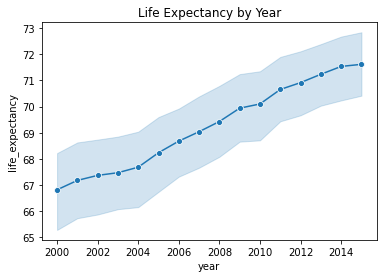

In [ ]:
sns.lineplot('year', 'life_expectancy', data=wins_df, marker='o')
plt.title('Life Expectancy by Year')
plt.show()

There appears to definitely be a positive trend over time, but is 15 years of data enough to make the year relevant to a model?

In [ ]:
wins_df.year.corr(wins_df.life_expectancy)

0.1697964496445902

There definitely appears to be a correlation, but are the differences between the years significant enough to be considered different? A t-test comparison will be used to find out.

In [ ]:
years = list(wins_df.year.unique())
years.sort()

In [ ]:
yearly_le = {}
for year in years:
    year_data = wins_df[wins_df.year == year].life_expectancy
    yearly_le[year] = year_data

In [ ]:
for year in years[:-1]:
    print(10*'-' + str(year) + ' to ' + str(year+1) + 10*'-')
    print(stats.ttest_ind(yearly_le[year], yearly_le[year+1], equal_var=False))

----------2000 to 2001----------
Ttest_indResult(statistic=-0.339874273786677, pvalue=0.734147249286317)
----------2001 to 2002----------
Ttest_indResult(statistic=-0.18288775743069652, pvalue=0.8549879128960569)
----------2002 to 2003----------
Ttest_indResult(statistic=-0.09788073999943862, pvalue=0.922080868750695)
----------2003 to 2004----------
Ttest_indResult(statistic=-0.20076791323205204, pvalue=0.8409921852108724)
----------2004 to 2005----------
Ttest_indResult(statistic=-0.5360239830703207, pvalue=0.5922696887371386)
----------2005 to 2006----------
Ttest_indResult(statistic=-0.43512464639644277, pvalue=0.6637298353979988)
----------2006 to 2007----------
Ttest_indResult(statistic=-0.35499521065847695, pvalue=0.7227988446996725)
----------2007 to 2008----------
Ttest_indResult(statistic=-0.39657900568183463, pvalue=0.6919107746155075)
----------2008 to 2009----------
Ttest_indResult(statistic=-0.5367008466564068, pvalue=0.5918023223783457)
----------2009 to 2010----------
T

Based on the above t-tests, year to year the differences between Life Expectancy do not appear to be significant.

What about status? There is definitely a difference in the amount of count of values between these two variables (found in the prior univariate analysis), but how about the difference between them with respect to Life Expectancy?

In [ ]:
wins_df.groupby('status').life_expectancy.agg(['mean'])

,mean
status,
Developed,79.197852
Developing,67.149077


It appears that 'Developed' countries have a much higher average Life Expectancy. But similar to the year comparisons above, is this difference significant? Again, a t-test comparison will be used to find out.

In [ ]:
developed_le = wins_df[wins_df.status == 'Developed'].life_expectancy
developing_le = wins_df[wins_df.status == 'Developing'].life_expectancy
stats.ttest_ind(developed_le, developing_le, equal_var=False)

Ttest_indResult(statistic=47.96440581661328, pvalue=2e-323)

Based on the result of the above t-test, there appears to be a very significant difference between 'Developing' and 'Developed' countries with respect to their Life Expectancy. Since this is the case, a comparison between the status variable and all other continuous variables should be made before moving to the feature engineering phase.

#### 2.2.3: Status Variable Compared to other Continuous Variables

Since the status variable only contains two different values, it is likely best to compare a number of descriptive statistics for those two values with respect to all the other continuous variables.

In [ ]:
wins_df_cols = list(wins_df.columns)
interested_vars = [wins_df_cols[2]]
for col in wins_df_cols[4:]:
    interested_vars.append(col)

In [ ]:
wins_df[interested_vars].groupby('status').agg('mean').transpose().round(0)

status,Developed,Developing
adult_mortality,97.0,185.0
infant_deaths,28.0,29.0
alcohol,10.0,4.0
percentage_expenditure,633.0,207.0
hepatitis_b,87.0,83.0
measles,127.0,240.0
under-five_deaths,35.0,39.0
polio,94.0,84.0
total_expenditure,7.0,6.0
diphtheria,94.0,84.0


From the above, it appears that many of these values are likely correlated to whether a country is 'Developed' or 'Developing'. Again, t-tests are the best way to find out if differences are significant here.

In [ ]:
developed_df = wins_df[wins_df.status == 'Developed']
developing_df = wins_df[wins_df.status == 'Developing']
for col in interested_vars[1:]:
    print(5*'-' + str(col) + ' Developed/Developing t-test comparison' + 5*'-')
    print('p-value=' +str(stats.ttest_ind(developed_df[col], developing_df[col], equal_var=False)[1]))

-----adult_mortality Developed/Developing t-test comparison-----
p-value=3.295961777163392e-145
-----infant_deaths Developed/Developing t-test comparison-----
p-value=0.43706003820584804
-----alcohol Developed/Developing t-test comparison-----
p-value=7.259688493240182e-204
-----percentage_expenditure Developed/Developing t-test comparison-----
p-value=1.0654031797381314e-67
-----hepatitis_b Developed/Developing t-test comparison-----
p-value=2.723238539034132e-12
-----measles Developed/Developing t-test comparison-----
p-value=2.938258449568768e-18
-----under-five_deaths Developed/Developing t-test comparison-----
p-value=0.0018370073332902765
-----polio Developed/Developing t-test comparison-----
p-value=3.1739264406706406e-118
-----total_expenditure Developed/Developing t-test comparison-----
p-value=1.1202855294470609e-39
-----diphtheria Developed/Developing t-test comparison-----
p-value=3.0189459362754654e-109
-----hiv/aids Developed/Developing t-test comparison-----
p-value=1.73

From the above, it is plain to see that there is a significant difference between the following variables with respect to a country's status:
- Adult Mortality
- Alcohol
- Percentage Expenditure
- Hepatitis B
- Measles
- Under Five Deaths
- Polio
- Total Expenditure
- Diphtheria
- HIV/AIDS
- GDP
- Population
- Thinness of 10 to 19 Year Olds
- Thinness of 5 to 9 Year Olds
- Income Composition of Resources
- Schooling

This implies that the status of a country is likely highly correlated to the above variables - also from earlier, it is significant in the difference between Life Expectancy as well. This variable should likely be included in our features in the next section. 

And now that the main comparisons have been made between all the relevant variables, it is now time to move on to the feature engineering phase of the EDA.

# Section 3: Feature Engineering

First off, since it is apparent that the status of a country should be included in some way in the final features of the data, one hot encoding will be conducted in order to include it in the future model.

In [ ]:
feat_df = wins_df.join(pd.get_dummies(wins_df.status)).drop(columns='status').copy()

In [ ]:
feat_df.iloc[:, 2:].corr().iloc[:, -2:]

,Developed,Developing
life_expectancy,0.483121,-0.483121
adult_mortality,-0.310207,0.310207
infant_deaths,-0.011644,0.011644
alcohol,0.580249,-0.580249
percentage_expenditure,0.420621,-0.420621
hepatitis_b,0.108121,-0.108121
measles,-0.130744,0.130744
under-five_deaths,-0.045339,0.045339
polio,0.265064,-0.265064
total_expenditure,0.284829,-0.284829


From the above it can be observed that whether a country is 'Developed' or not is certainly correlated with a number of variables, but not extremely highly. However, it does have a very low correlation with Infant Deaths, Under Five Deaths and Population.

Next, the categorical columns, 'year' and 'country' will be dropped as they don't have significant differences among life expectancy.

In [ ]:
feat_df=feat_df.drop(columns=['country', 'year','life_expectancy','Developed','Developing'], axis=1)
feat_df.head(10)

,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_10-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,263.0,62.000000,0.010000,71.279624,65.0,831,83.000000,52.0,8.16,65.0,0.1,584.259210,2.865628e+07,15.3,15.5,0.479,10.1
16,74.0,35.129032,4.600000,364.975229,99.0,0,44.844961,99.0,6.00,99.0,0.1,3954.227830,2.887300e+04,1.2,1.3,0.762,14.2
32,19.0,21.000000,5.288333,0.000000,95.0,63,24.000000,95.0,7.08,95.0,0.1,4132.762920,2.865628e+07,6.0,5.8,0.743,14.4
48,335.0,66.000000,5.288333,0.000000,64.0,118,98.000000,52.0,7.08,64.0,1.8,3695.793748,2.785935e+06,8.3,8.2,0.531,11.4
64,13.0,35.129032,5.288333,0.000000,99.0,0,44.844961,86.0,7.08,99.0,0.2,13566.954100,1.109741e+07,3.3,3.3,0.784,13.9
80,116.0,8.000000,5.288333,0.000000,94.0,0,9.000000,93.0,7.08,94.0,0.1,13467.123600,2.865628e+07,1.0,0.9,0.826,17.3
96,118.0,1.000000,5.288333,0.000000,94.0,33,1.000000,96.0,7.08,94.0,0.1,369.654776,2.916950e+05,2.1,2.2,0.741,12.7
112,59.0,1.000000,5.288333,0.000000,93.0,74,1.000000,93.0,7.08,93.0,0.1,16784.346160,2.378934e+07,0.6,0.6,0.937,19.5
128,65.0,35.129032,5.288333,0.000000,93.0,309,44.844961,93.0,7.08,93.0,0.1,16784.346160,8.633169e+06,1.9,2.1,0.892,15.9
144,118.0,5.000000,5.288333,0.000000,96.0,0,6.000000,98.0,7.08,96.0,0.1,55.313820,9.649341e+06,2.8,2.9,0.758,12.7


From the prior analysis, there are a number of variables that are very or extremely highly correlated with one another. In those cases, the variable which is most highly correlated to Life Expectancy (target variable) will be kept while the others will be dismissed.

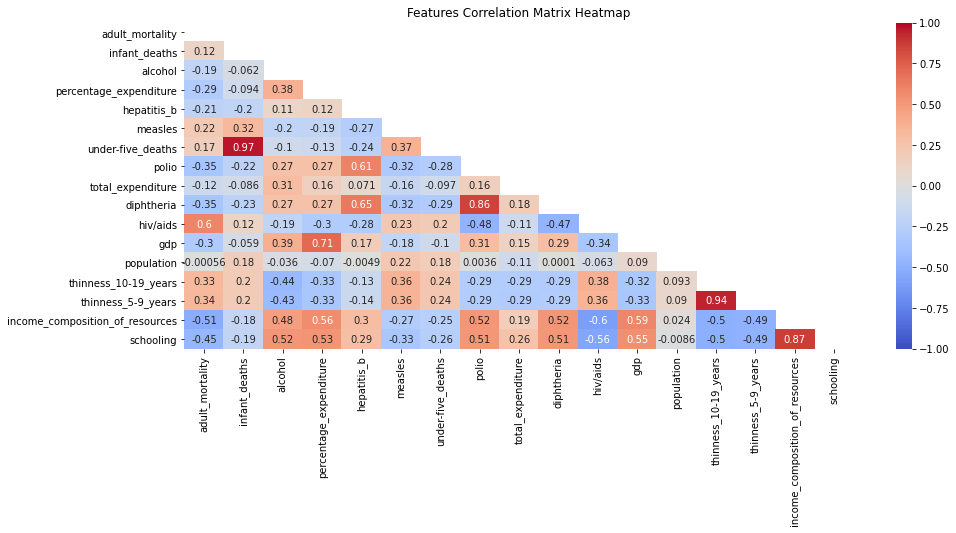

In [ ]:
def feat_heatmap():
    mask = np.triu(feat_df.corr())
    plt.figure(figsize=(15,6))
    sns.heatmap(feat_df.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
    plt.ylim(len(feat_df.columns), 0)
    plt.title('Features Correlation Matrix Heatmap')
    plt.show()
feat_heatmap()

In [ ]:
feat_df.columns

Index(['adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure',
       'hepatitis_b', 'measles', 'under-five_deaths', 'polio',
       'total_expenditure', 'diphtheria', 'hiv/aids', 'gdp', 'population',
       'thinness_10-19_years', 'thinness_5-9_years',
       'income_composition_of_resources', 'schooling'],
      dtype='object')

#### Principal Component Analysis


It may be useful to run a Principal Components Analysis (PCA) on this data to reduce the amount of dimensions (features). But there are a number of assumptions/requirements when it comes to PCA:
- Continuous data: the data used should be of a continuous type
- Sample size: the sample size should have between 5-10 samples per feature
- Normalized data: the data is generally normally distributed
- Correlation: there should be correlation between the features
- Linearity: it is assumed that relationships between features are linear
- Outliers: PCA is sensitive to outliers, therefore outliers should not be present

The features set currently satisfies 3 of the above assumptions: sample size, correlation, outliers. The linearity assumption may not be true, the data is not currently normalized and not all the data is continuous - the developed indicator is categorical. First the 'Developed' variable should be removed.

In [ ]:
from sklearn.model_selection import train_test_split
y = wins_df['life_expectancy']
x = feat_df

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=101)
pca_df_train = x_train.copy()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(2056, 17)
(882, 17)
(2056,)
(882,)


PCA is an unsupervised technique so the target variable is not needed and can be dropped.

In [ ]:
len(pca_df_train.columns)

17

In [ ]:
# Setup PCA model  
n_components = 7
pca = PCA(n_components)
# fit the standardized real train data to model & transform to PCA
pca_train = pd.DataFrame(pca.fit_transform(pca_df_train))
pca_train.columns=['pca1','pca2','pca3','pca4','pca5','pca6','pca7']
pca_train.head(10)

,pca1,pca2,pca3,pca4,pca5,pca6,pca7
0,-4.474150e+06,-4792.482181,591.008663,-24.127604,-8.154297,-60.513666,-13.224046
1,-5.693990e+06,-4234.147290,-217.692017,7.836378,-119.538307,-30.518219,-5.623202
2,-6.867430e+06,3515.555709,-186.310343,-569.550273,8.383688,-16.558842,-7.434941
3,-3.535642e+06,9450.328173,-3.856657,552.158141,29.808473,-36.435128,-5.693716
4,-2.095906e+06,-4943.478550,113.896692,26.067800,145.080133,-30.838492,23.809608
5,5.430133e+06,-4950.965954,-272.276223,53.776802,246.409613,-1.589566,18.586084
6,-6.407530e+06,-4691.113139,619.021203,-9.147291,104.651173,-10.285710,14.637855
7,-3.435464e+06,-4219.336794,596.356795,-29.617350,34.253935,45.979203,0.214170
8,-4.679089e+06,-3095.153697,-205.955323,32.626877,56.097383,-38.378828,-17.617551
9,-7.346096e+06,12154.136054,-25.788170,-134.576819,-20.938456,-24.285415,5.981242


In [ ]:
eigenvectors = np.round(pca.components_.transpose(),decimals=3)
print (f'eigenvectors: {eigenvectors}')


eigenvectors: [[-0.    -0.006  0.059  0.034  0.995 -0.047 -0.051]
 [ 0.    -0.     0.023  0.     0.017  0.562 -0.097]
 [-0.     0.    -0.001 -0.002 -0.001 -0.002 -0.017]
 [-0.     0.052 -0.119 -0.991  0.041  0.004  0.001]
 [ 0.     0.    -0.01   0.003 -0.021 -0.048 -0.5  ]
 [ 0.    -0.012  0.99  -0.122 -0.058 -0.043 -0.013]
 [ 0.    -0.001  0.038  0.     0.036  0.819 -0.057]
 [ 0.     0.001 -0.013 -0.002 -0.034 -0.058 -0.606]
 [-0.     0.    -0.001 -0.    -0.001 -0.002 -0.007]
 [ 0.     0.001 -0.013 -0.002 -0.036 -0.064 -0.605]
 [-0.    -0.     0.     0.     0.003  0.001  0.007]
 [ 0.     0.999  0.019  0.05   0.003 -0.     0.001]
 [ 1.    -0.    -0.    -0.     0.    -0.     0.   ]
 [ 0.    -0.     0.004  0.001  0.007  0.007  0.002]
 [ 0.    -0.     0.004  0.001  0.008  0.007  0.002]
 [ 0.     0.    -0.    -0.    -0.001 -0.    -0.002]
 [-0.     0.    -0.002 -0.002 -0.008 -0.008 -0.034]]


In [ ]:
eigenvalues = pca.explained_variance_
print (f'eigenvalues: {eigenvalues}')

eigenvalues: [7.39330587e+13 2.98593971e+07 9.82448532e+04 6.82925226e+04
 1.02558702e+04 1.75016955e+03 3.99541235e+02]


In [ ]:
loadings= (np.sqrt(eigenvalues)*-1)*eigenvectors
print(f'PCA Loadings: {loadings}')

PCA Loadings: [[ 0.00000000e+00  3.27862516e+01 -1.84929807e+01 -8.88516495e+00
  -1.00764914e+02  1.96624630e+00  1.01941491e+00]
 [-0.00000000e+00  0.00000000e+00 -7.20912806e+00 -0.00000000e+00
  -1.72161160e+00 -2.35112856e+01  1.93888718e+00]
 [ 0.00000000e+00 -0.00000000e+00  3.13440350e-01  5.22656762e-01
   1.01271271e-01  8.36700555e-02  3.39804969e-01]
 [ 0.00000000e+00 -2.84147514e+02  3.72994017e+01  2.58976425e+02
  -4.15212209e+00 -1.67340111e-01 -1.99885276e-02]
 [-0.00000000e+00 -0.00000000e+00  3.13440350e+00 -7.83985142e-01
   2.12669668e+00  2.00808133e+00  9.99426380e+00]
 [-0.00000000e+00  6.55725032e+01 -3.10305947e+02  3.18820625e+01
   5.87373369e+00  1.79890619e+00  2.59850859e-01]
 [-0.00000000e+00  5.46437527e+00 -1.19107333e+01 -0.00000000e+00
  -3.64576574e+00 -3.42628877e+01  1.13934607e+00]
 [-0.00000000e+00 -5.46437527e+00  4.07472455e+00  5.22656762e-01
   3.44322320e+00  2.42643161e+00  1.21130477e+01]
 [ 0.00000000e+00 -0.00000000e+00  3.13440350e-01 

In [ ]:
train_loadings_table = pd.DataFrame(data=pca.components_.T, index=pca_df_train.columns).round(6)
train_loadings_table.columns=['pca1','pca2','pca3','pca4','pca5','pca6','pca7']
train_loadings_table

,pca1,pca2,pca3,pca4,pca5,pca6,pca7
adult_mortality,-0.000000,-0.006221,0.059431,0.033605,0.995136,-0.047096,-0.050664
infant_deaths,0.000001,-0.000287,0.022602,0.000244,0.016570,0.561645,-0.096735
alcohol,-0.000000,0.000289,-0.001480,-0.001757,-0.001221,-0.001804,-0.016655
percentage_expenditure,-0.000003,0.052054,-0.118570,-0.990706,0.041160,0.004230,0.000918
hepatitis_b,0.000000,0.000397,-0.009581,0.002505,-0.020861,-0.048056,-0.499778
measles,0.000008,-0.012376,0.989768,-0.121717,-0.057842,-0.042999,-0.013212
under-five_deaths,0.000001,-0.000698,0.037926,0.000341,0.035949,0.818866,-0.057127
polio,0.000000,0.000864,-0.012795,-0.001577,-0.034394,-0.058156,-0.605678
total_expenditure,-0.000000,0.000070,-0.000903,-0.000411,-0.001383,-0.002068,-0.006952
diphtheria,0.000000,0.000820,-0.012999,-0.002003,-0.035801,-0.063674,-0.605370


### Comparing Original and Synthetic Dataset

In [ ]:
S_train = pd.DataFrame(pca.inverse_transform(pca_train), columns=pca_df_train.columns)

### Summary Statistics of Original and Synthetic Dataset

In [ ]:
# Compare Summary Stats
np.round(pca_df_train.describe().transpose(),decimals=2)


,count,mean,std,min,25%,50%,75%,max
adult_mortality,2056.0,167.84,108.36,13.00,82.00,153.00,225.00,428.00
infant_deaths,2056.0,28.17,25.46,1.00,4.00,27.00,43.77,95.00
alcohol,2056.0,4.70,3.89,0.01,1.17,4.22,7.55,15.14
percentage_expenditure,2056.0,286.02,387.43,0.00,5.26,66.55,459.50,1077.71
hepatitis_b,2056.0,83.82,13.69,55.00,74.10,87.00,96.00,99.00
measles,2056.0,216.51,326.58,0.00,0.00,16.50,336.75,831.00
under-five_deaths,2056.0,37.98,37.32,1.00,4.00,33.00,60.01,138.00
polio,2056.0,85.62,15.26,52.00,78.00,93.00,97.00,99.00
total_expenditure,2056.0,6.00,2.33,0.37,4.40,5.93,7.39,11.66
diphtheria,2056.0,85.64,15.13,52.00,78.00,93.00,97.00,99.00


In [ ]:
np.round(S_train.describe().transpose(),decimals=2)

,count,mean,std,min,25%,50%,75%,max
adult_mortality,2056.0,167.84,108.36,12.76,82.17,153.10,224.99,428.13
infant_deaths,2056.0,28.17,25.10,-0.26,4.90,24.83,43.83,97.00
alcohol,2056.0,4.70,1.75,1.74,3.47,4.30,5.50,8.69
percentage_expenditure,2056.0,286.02,387.43,-0.08,5.28,66.56,459.49,1077.83
hepatitis_b,2056.0,83.82,11.07,52.71,76.80,87.38,92.60,98.29
measles,2056.0,216.51,326.58,-0.09,0.01,16.50,336.75,831.07
under-five_deaths,2056.0,37.98,37.21,-1.12,3.70,32.81,59.37,139.65
polio,2056.0,85.62,14.25,50.63,76.13,91.62,97.14,102.32
total_expenditure,2056.0,6.00,0.58,4.28,5.66,6.06,6.38,7.19
diphtheria,2056.0,85.64,14.27,50.34,76.29,91.61,97.17,101.92


### Correlation Matrices of Original & Synthetic Dataset

Text(0.5, 1.0, 'Original Data Features Correlation Matrix Heatmap')

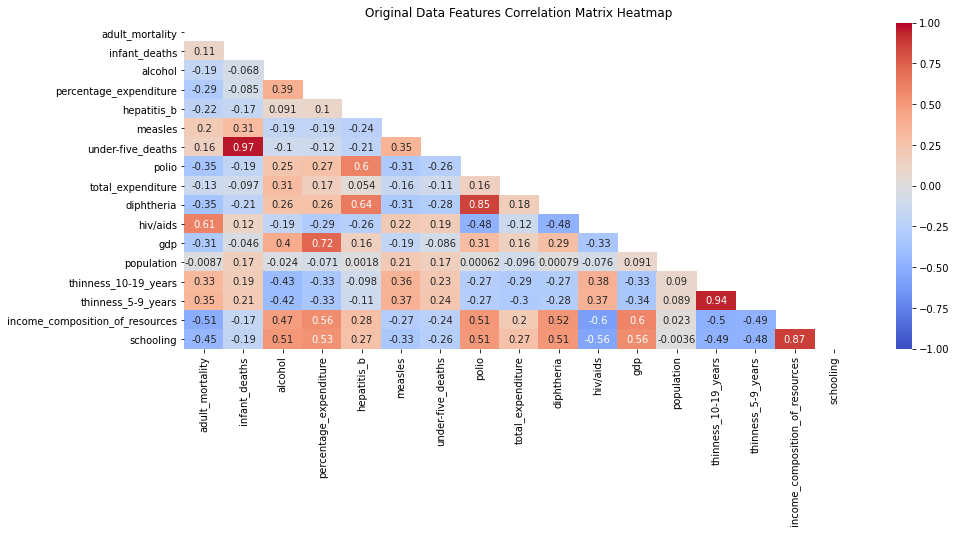

In [ ]:
mask = np.triu(pca_df_train.corr())
plt.figure(figsize=(15,6))
sns.heatmap(pca_df_train.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
plt.ylim(len(pca_df_train.columns), 0)
plt.title('Original Data Features Correlation Matrix Heatmap')

Text(0.5, 1.0, 'Synthetic Data Features Correlation Matrix Heatmap')

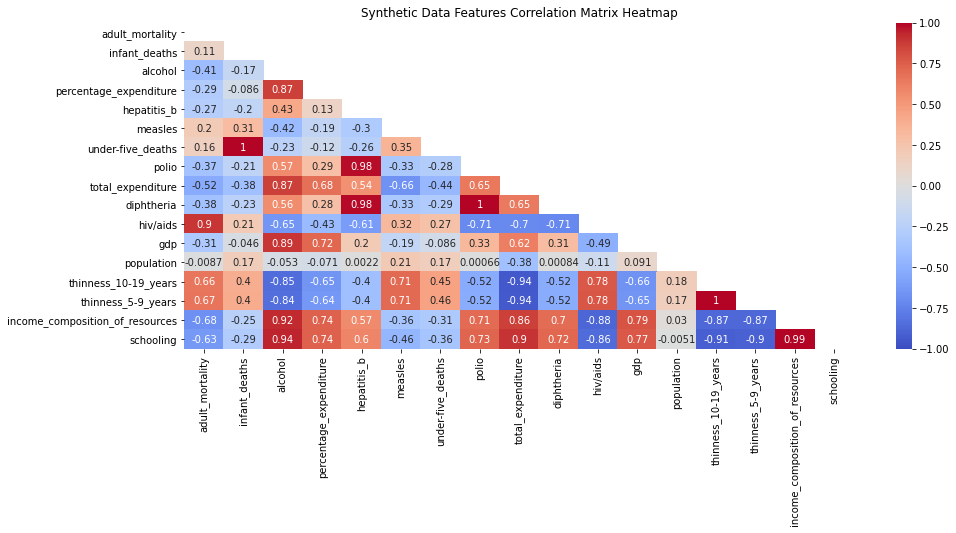

In [ ]:
mask = np.triu(S_train.corr())
plt.figure(figsize=(15,6))
sns.heatmap(S_train.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
plt.ylim(len(S_train.columns), 0)
plt.title('Synthetic Data Features Correlation Matrix Heatmap')

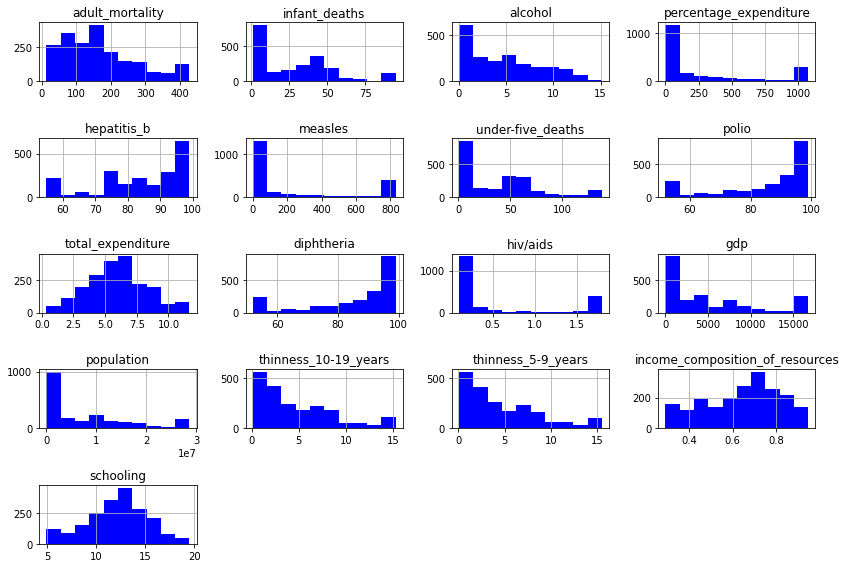

In [ ]:
#Compare historgams
pca_df_train.hist(grid=True, figsize=(12,8), color='blue')
plt.tight_layout()

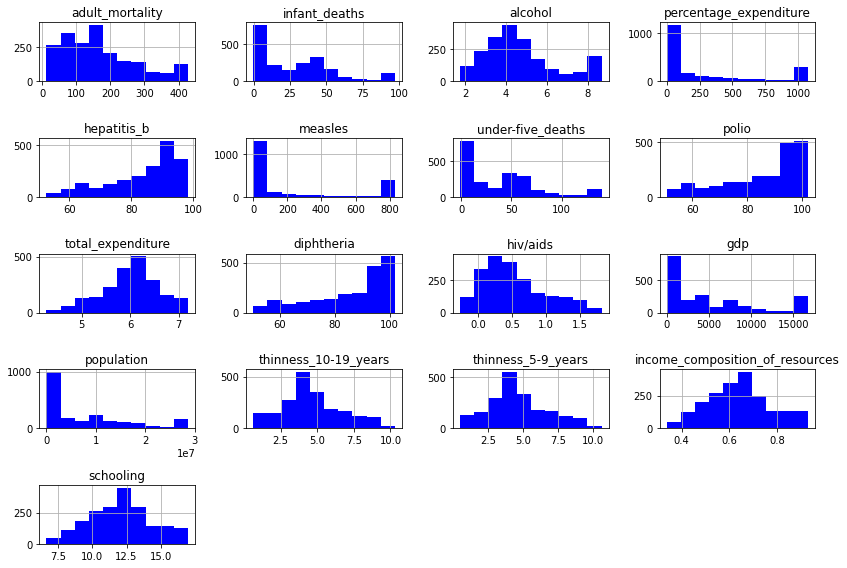

In [ ]:
S_train.hist(grid=True, figsize=(12,8), color='blue')
plt.tight_layout()

### Random Forest Evaluator Performance


In [ ]:
def model_metrics (model, x_test, y_test):
    from sklearn.metrics import r2_score, mean_squared_error
    y_pred=model.predict(x_test)
    r2=r2_score(y_test, y_pred).round(2)
    rms = np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
    return (print('R2 Score of', type(model).__name__, ':',r2),
          print('Root Mean Squared Error Score of', type(model).__name__, ':',rms))
    

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=60, n_jobs=-1, max_depth=6,random_state=4,criterion='mae',oob_score=True)
rf.fit(S_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=60, n_jobs=-1, oob_score=True,
                      random_state=4, verbose=0, warm_start=False)

In [ ]:
rf.oob_score_.round(2)

0.88

In [ ]:
model_metrics (rf, x_test, y_test)

R2 Score of RandomForestRegressor : 0.88
Root Mean Squared Error Score of RandomForestRegressor : 3.17


(None, None)

### XGBoost Validator

In [ ]:
from xgboost import XGBRegressor

xgb=XGBRegressor(objective='reg:squarederror',n_estimators=50, learning_rate=0.15,
                 seed=2,colsample_bytree=0.5,reg_alpha=0,reg_lambda=0.8,base_score=0.1)
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.1, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.15, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=0.8, scale_pos_weight=1,
             seed=2, silent=None, subsample=1, verbosity=1)

In [ ]:
model_metrics (xgb, x_test, y_test)

R2 Score of XGBRegressor : 0.91
Root Mean Squared Error Score of XGBRegressor : 2.76


(None, None)

### Cross Validation Results of Evaluator and Validator


In [ ]:
from sklearn.model_selection import cross_validate

# cross validate
scores_rf = cross_validate(rf, S_train, y_train, cv=5,
                        return_train_score=True,
                        return_estimator=False)
scores_rf=pd.DataFrame(scores_rf)
scores_rf

,fit_time,score_time,test_score,train_score
0,8.241458,0.104140,0.855607,0.906562
1,6.941478,0.103617,0.882802,0.916941
2,6.914122,0.103801,0.886082,0.917701
3,6.682378,0.103752,0.901223,0.922588
4,7.013229,0.103978,0.873062,0.920505


In [ ]:
print('Mean Test Score of Random Forest Regressor: ', np.round(scores_rf['test_score'].mean(),2))
print('Mean Train Score of Random Forest Regressor: ', np.round(scores_rf['train_score'].mean(),2))

Mean Test Score of Random Forest Regressor:  0.88
Mean Train Score of Random Forest Regressor:  0.92


In [ ]:
# cross validate
scores_xgb = cross_validate(xgb, x_train, y_train, cv=5,
                        return_train_score=True,
                        return_estimator=False)
scores_xgb=pd.DataFrame(scores_xgb)
scores_xgb

,fit_time,score_time,test_score,train_score
0,0.059176,0.002684,0.937020,0.950857
1,0.054112,0.002590,0.934076,0.946847
2,0.053963,0.002692,0.919495,0.949659
3,0.054107,0.002555,0.931156,0.952268
4,0.053744,0.002628,0.928419,0.949702


In [ ]:
print('Mean Test Score of XGBoost Regressor: ', np.round(scores_xgb['test_score'].mean(),2))
print('Mean Train Score of XGBoost Regressor: ', np.round(scores_xgb['train_score'].mean(),2))

Mean Test Score of XGBoost Regressor:  0.93
Mean Train Score of XGBoost Regressor:  0.95


### Feature Importance Ratings of Evaluator and Validator

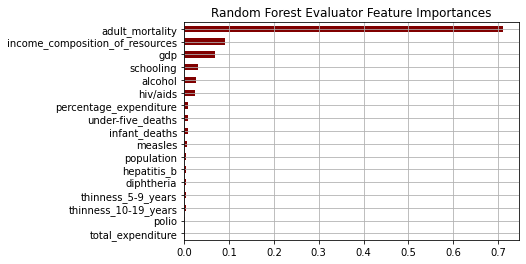

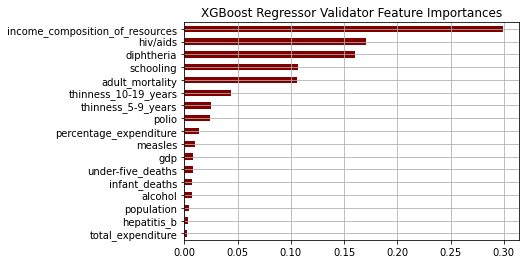

In [ ]:
def plot_feature_importances (model, kind, title, color, dataframe):
    importances = pd.Series(data=model.feature_importances_, index= dataframe.columns)
    # Sort importances
    importances_sorted = importances.sort_values()
    # Draw a horizontal barplot of importances_sorted
    importances_sorted.plot(kind=kind, color=color)
    plt.title(title)
    plt.grid()
    return(plt.show())

plot_feature_importances (rf, 'barh', 'Random Forest Evaluator Feature Importances', 'maroon', x_train)
plot_feature_importances (xgb, 'barh', 'XGBoost Regressor Validator Feature Importances', 'maroon', x_test)

### Percentage Error/Residual Interval Distribution

In [ ]:
y_pred_rf = rf.predict(x_test) 
diff_rf = y_pred_rf - y_test
residuals=pd.concat([pd.DataFrame(diff_rf),pd.DataFrame(y_test)],axis=1).reset_index()
residuals.columns=['case_number','life_expectancy_residual','life_expectancy']
residuals['percentage_error']=(residuals['life_expectancy_residual']/residuals['life_expectancy'])*100
residuals['percentage_error_interval'] = pd.cut(residuals['percentage_error'], bins=[-float("inf"),-30,-20,-10,-5, 0, 5, 10, 20, 30,float("inf")])
grouped_residuals = residuals.groupby('percentage_error_interval')['case_number'].count().reset_index()
# Percentage of projects under each interval
grouped_residuals['percentage_projects']=(grouped_residuals['case_number']/grouped_residuals['case_number'].sum())*100
grouped_residuals.round(2)

,percentage_error_interval,case_number,percentage_projects
0,"(-inf, -30.0]",0,0.00
1,"(-30.0, -20.0]",1,0.11
2,"(-20.0, -10.0]",19,2.15
3,"(-10.0, -5.0]",92,10.43
4,"(-5.0, 0.0]",387,43.88
5,"(0.0, 5.0]",326,36.96
6,"(5.0, 10.0]",38,4.31
7,"(10.0, 20.0]",15,1.70
8,"(20.0, 30.0]",1,0.11
9,"(30.0, inf]",3,0.34


In [ ]:
y_pred_xgb = xgb.predict(x_test)
diff_xgb = y_pred_xgb - y_test 
residuals=pd.concat([pd.DataFrame(diff_xgb),pd.DataFrame(y_test)],axis=1).reset_index()
residuals.columns=['case_number','life_expectancy_residual','life_expectancy']
residuals['percentage_error']=(residuals['life_expectancy_residual']/residuals['life_expectancy'])*100
residuals['percentage_error_interval'] = pd.cut(residuals['percentage_error'], bins=[-float("inf"),-30,-20,-10,-5, 0, 5, 10, 20, 30,float("inf")])
grouped_residuals = residuals.groupby('percentage_error_interval')['case_number'].count().reset_index()
# Percentage of projects under each interval
grouped_residuals['percentage_projects']=(grouped_residuals['case_number']/grouped_residuals['case_number'].sum())*100
grouped_residuals.round(2)

,percentage_error_interval,case_number,percentage_projects
0,"(-inf, -30.0]",0,0.00
1,"(-30.0, -20.0]",0,0.00
2,"(-20.0, -10.0]",13,1.47
3,"(-10.0, -5.0]",76,8.62
4,"(-5.0, 0.0]",312,35.37
5,"(0.0, 5.0]",419,47.51
6,"(5.0, 10.0]",49,5.56
7,"(10.0, 20.0]",6,0.68
8,"(20.0, 30.0]",6,0.68
9,"(30.0, inf]",1,0.11


### Model Residual Distributions

Text(0, 0.5, 'Frequency')

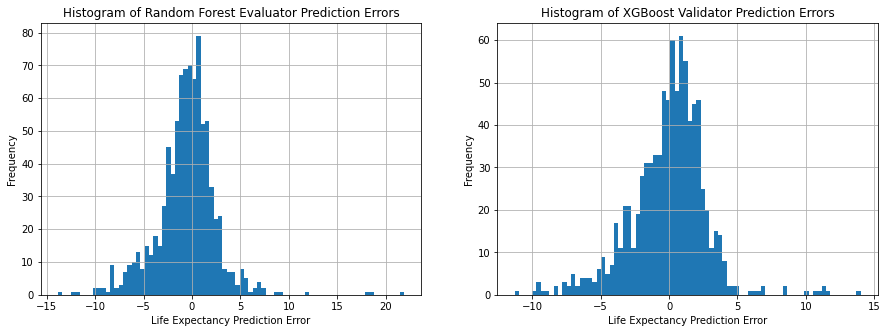

In [ ]:
fig = plt.figure(figsize=(15,5))

plt.subplot(121)
diff_rf.hist(bins = 80)
plt.title('Histogram of Random Forest Evaluator Prediction Errors')
plt.xlabel('Life Expectancy Prediction Error')
plt.ylabel('Frequency')

plt.subplot(122)
diff_xgb.hist(bins = 80)
plt.title('Histogram of XGBoost Validator Prediction Errors')
plt.xlabel('Life Expectancy Prediction Error')
plt.ylabel('Frequency')

### Life Expectancy Actual vs Model Predicted Values

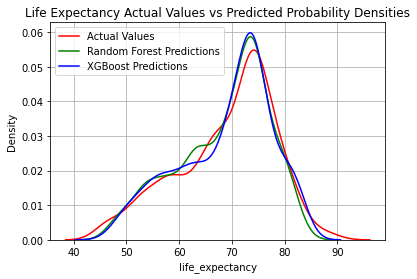

In [ ]:
plt.title('Life Expectancy Actual Values vs Predicted Probability Densities')
sns.kdeplot(y_test, color="r", label="Actual Values")
sns.kdeplot(y_pred_rf,color="g", label="Random Forest Predictions")
sns.kdeplot(y_pred_xgb, color="b", label="XGBoost Predictions")
plt.legend()
plt.grid()

## Section 4: In Summary

In summation, synthetic data have been generated using PCA for 7 out of the 17 variables.


The first step was to clean the data, this included detecting and dealing with both missing values and outliers. The variables and dataset were given a general description so that a better understanding of what the variables mean could be gathered. Then both explicit and inexplicit missing values were detected. Inexplicit missing values were values that didn't make sense for a variable given the nature of the data. There were a number of seemingly nonsensical values found given many variables' descriptions. Those inexplicit missing values were then converted to explicit missing values or nulls. Interpolation would have likely been the best method to deal with the now explicit null values (since it is time series data), but interpolation in this case would not have garnered any results. Therefore, the next best thing was done instead, imputation based on the means of all countries by year. Once missing values were sorted, the next step was detecting and dealing with outliers. Extreme value detection was done primarily by using standard box and whisker plots with a standard IQR threshold of 1.5. Using this technique, each variable's data was winsorized on a one by one basis to eliminate outliers while limiting the loss of data. Once this step was complete, exploration of the data could be conducted. 

The now clean dataset was then analyzed using univariate and bivariate techniques. One of the univariate techniques used was to inspect continuous variables using histograms in order to get an idea of their distributions. The general descriptive statistics were also found for the continuous variables. After that, categorical count plots were created to get an idea of the 'distribution' of categorical data. From that analysis it was discovered that the majority of the data fell under the 'Developing' country status. With the univariate analysis complete, it was time to move on to bivariate analysis. Bivariate analysis definitely laid most of the groundwork for understanding the relationships not only between the target variable (Life Expectancy) and the other variables, but also every variable compare to one another. The primary method used in the bivariate analysis was by the use of the correlation matrix in conjunction with the heatmap visual from the Seaborn library. This took care of the main comparisons between continuous to continuous data and was the main foundation for feature selection. But before moving on to feature engineering, some categorical variables were compared to the target variable. It was found that 'Life Expectancy' with respect to year did not garner significant enough difference to use in analysis. However, it was found that the 'Status' of a country did have a significant effect on 'Life Expectancy'. In addition to 'Life Expectancy' it also appeared to be significantly different for a number of other continuous variables. It is for this reason that new indicator variables, 'Developed' and 'Developing', were created in the next section, feature engineering.

Finally, feature engineering.